In [1]:
import pandas as pd
from finta import TA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)
df

,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,
2010-07-24,0.0545,0.0545,0.0545,0.0545,0.000000e+00,0.000000e+00
2010-07-25,0.0505,0.0505,0.0505,0.0505,0.000000e+00,0.000000e+00
2010-07-26,0.0560,0.0560,0.0560,0.0560,0.000000e+00,0.000000e+00
2010-07-27,0.0600,0.0600,0.0600,0.0600,0.000000e+00,0.000000e+00
2010-07-28,0.0589,0.0589,0.0589,0.0589,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2023-08-18,26659.8500,26784.2300,25721.5300,26058.2600,7.032831e+10,5.115170e+11
2023-08-19,26069.2300,26253.2600,25814.2500,26090.6300,4.769626e+10,5.060530e+11
2023-08-20,26085.1800,26267.3300,26002.0300,26180.0000,3.624048e+10,5.084380e+11


In [6]:
# Calculate ADX
df['ADX'] = TA.ADX(df)

# Calculate RSI
df['RSI'] = TA.RSI(df)

# Calculate Bollinger Bands
bollinger_bands = TA.BBANDS(df)
df['BollingerUpper'] = bollinger_bands['BB_UPPER']
df['BollingerMiddle'] = bollinger_bands['BB_MIDDLE']
df['BollingerLower'] = bollinger_bands['BB_LOWER']

df.dropna(inplace=True)

In [7]:
def label_market(df, criteria):
    df['MarketLabel'] = 0
    indices = df.index.tolist()
    
    for i in range(len(indices)):
        current_index = indices[i]
        trendy_count = 0
        
        if df.loc[current_index, 'ADX'] > 25:
            trendy_count += 1
        
        if df.loc[current_index, 'RSI'] < 30 or df.loc[current_index, 'RSI'] > 70:
            trendy_count += 1

        if i > 0:
            previous_index = indices[i-1]
            current_width = df.loc[current_index, 'BollingerUpper'] - df.loc[current_index, 'BollingerLower']
            previous_width = df.loc[previous_index, 'BollingerUpper'] - df.loc[previous_index, 'BollingerLower']
            
            if current_width > previous_width:
                trendy_count += 1

        if trendy_count >= criteria:
            df.loc[current_index, 'MarketLabel'] = 1  # Trendy
            
    return df

In [8]:
def plot_colored_market_trends(df):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for date, row in df.iterrows():
        current_price = row['Close']
        current_label = row['MarketLabel']
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

In [9]:
df.head(30)
df=label_market(df,2)


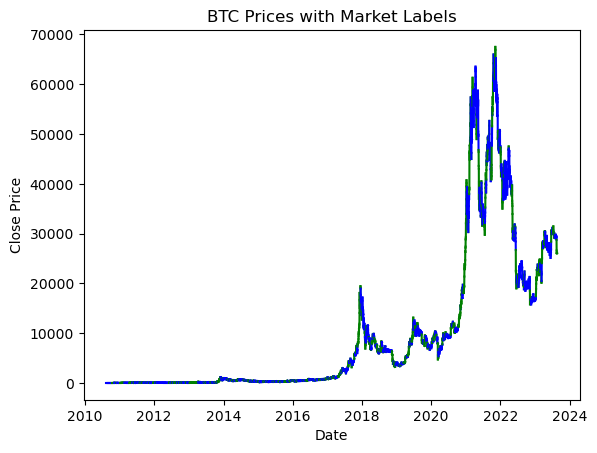

In [10]:
plot_colored_market_trends(df)

In [11]:
df['MarketLabel'].value_counts()

0    2921
1    1838
Name: MarketLabel, dtype: int64

In [12]:
X = df.drop(columns=["MarketLabel"])
y = df["MarketLabel"]

In [13]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [14]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

SVM Model 

In [15]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(svm_pred)

[0 0 0 ... 0 0 1]


In [16]:
accuracy_score(y_test, svm_pred)

0.8327731092436975

In [17]:
# Generate a confusion matrix for the model

confusion_matrix(y_test, svm_pred)

array([[712,  30],
       [169, 279]])

In [18]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       742
           1       0.90      0.62      0.74       448

    accuracy                           0.83      1190
   macro avg       0.86      0.79      0.81      1190
weighted avg       0.84      0.83      0.82      1190



In [19]:
# gradient bosting - Haywar 
# neural network - Nariman 
# logistic regressionaccuracy_score(y_test, predictions) - Ramees 
# random forest - Ramees 
# LSM models  - Vishnu 


Logistics Regression 

In [20]:

lg_model = LogisticRegression(random_state=1)  

# Fit the model using training data
lg_model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

In [21]:
lg_predictions = lg_model.predict(X_test_scaled)

In [22]:
accuracy_score(y_test, lg_predictions)

0.6899159663865546

In [23]:
confusion_matrix(y_test, lg_predictions)

array([[630, 112],
       [257, 191]])

In [25]:
print(classification_report(y_test, lg_predictions))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       742
           1       0.63      0.43      0.51       448

    accuracy                           0.69      1190
   macro avg       0.67      0.64      0.64      1190
weighted avg       0.68      0.69      0.67      1190



Random Forest 

In [27]:
rf_model = RandomForestClassifier(random_state=1)

# Fit the model using training data
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=1)

In [28]:
rf_predictions = rf_model.predict(X_test_scaled)

In [29]:
accuracy_score(y_test, rf_predictions)

0.8932773109243698

In [30]:
confusion_matrix(y_test, rf_predictions)

array([[694,  48],
       [ 79, 369]])

In [31]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       742
           1       0.88      0.82      0.85       448

    accuracy                           0.89      1190
   macro avg       0.89      0.88      0.88      1190
weighted avg       0.89      0.89      0.89      1190

